In [336]:
#Importing the necessary attributes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation,TimeDistributed
from tensorflow.keras.models import Sequential
from keras.layers import SimpleRNN
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statistics import stdev

%matplotlib inline

In [337]:
#Open the dataset 
dataset = pd.read_csv('Desktop/GOOGL.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [338]:
dataset.shape

(4431, 7)

In [339]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB


In [340]:
dataset.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [341]:
dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [342]:
# change date type to datetime type 
dataset.Date=pd.to_datetime(dataset['Date'])

In [343]:
dataset.Date.min(),dataset.Date.max()

(Timestamp('2004-08-19 00:00:00'), Timestamp('2022-03-24 00:00:00'))

In [344]:
#how many day
dataset.Date.max()-dataset.Date.min()

Timedelta('6426 days 00:00:00')

In [345]:
dataset.set_index('Date',inplace=True)

In [346]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [347]:
#split the data into chunks and 
# then just compute statistics for each one of
#those different chunks. 
#Then large deviations in either the mean or 
#variance amongst those chunks would suggest us 
#that the data is probably not stationary
np.round(dataset.shape[0]/10,0)

443.0

In [348]:

mean=[]
std=[]
    
for i in range(0,10):
    mean.append(dataset['High'].iloc[(i*443):(i*443)+443].mean())
    std.append(stdev(dataset['High'].iloc[(i*443):(i*443)+443]))

In [349]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)

,mean,std
0,140.365196,51.153975
1,253.262980,46.102784
2,220.912289,43.122744
3,277.775461,24.652126
4,338.114265,47.663683
5,537.664131,54.208791
6,710.515983,88.280105
7,1021.089795,126.361815
8,1229.109186,124.523716
9,2263.732568,524.220412


In [350]:
# both measures are clearly different in each chunk 
# Assume non-stationary
#Need more test

In [351]:
#Augmented Dickey-Fuller
result = adfuller(dataset['High'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.414008
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [352]:
#The p-value is obtained is greater than significance level 
#of 0.05 and the ADF statistic is higher than any of 
#the critical values.
#Clearly, there is no reason to reject the null hypothesis.
#So, the time series is in fact non-stationary.

#Give us information that the prediction will take more time
#to train such type


In [353]:
#Change dataset
new_dataset=dataset['High'].iloc[:-4]

In [354]:
# Split train 80 and test 20
train_len = math.ceil(len(new_dataset)*0.8)
train_len

3542

In [355]:
# random steps 
step=10
train_data = new_dataset[0:train_len]

X_train=[]
Y_train=[]

for i in range(step, len(train_data)):
    X_train.append(train_data[i-step:i])
    Y_train.append(train_data[i])
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [356]:
#Reshaping train data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3532, 10, 1)

In [357]:
X_train

array([[[  52.082081],
        [  54.594597],
        [  56.796799],
        ...,
        [  52.797798],
        [  51.906906],
        [  51.536537]],

       [[  54.594597],
        [  56.796799],
        [  55.855858],
        ...,
        [  51.906906],
        [  51.536537],
        [  51.236237]],

       [[  56.796799],
        [  55.855858],
        [  54.054054],
        ...,
        [  51.536537],
        [  51.236237],
        [  50.920921]],

       ...,

       [[1237.400024],
        [1257.869995],
        [1256.560059],
        ...,
        [1214.869995],
        [1198.98999 ],
        [1188.550049]],

       [[1257.869995],
        [1256.560059],
        [1267.170044],
        ...,
        [1198.98999 ],
        [1188.550049],
        [1186.660034]],

       [[1256.560059],
        [1267.170044],
        [1269.48999 ],
        ...,
        [1188.550049],
        [1186.660034],
        [1190.939941]]])

In [358]:
#Model LSTM
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))

#Compile LSTM
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_137 (LSTM)             (None, 50)                10400     
                                                                 
 dense_230 (Dense)           (None, 25)                1275      
                                                                 
 dense_231 (Dense)           (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [359]:
#Split test data
test_data = new_dataset[train_len-steps:]

X_test=[]
Y_test=[] 

for i in range(step, len(test_data)):
    X_test.append(test_data[i-step:i])
    Y_test.append(test_data[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [360]:
#Reshaping data test
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [361]:
X_test.shape, Y_test.shape

((885, 10, 1), (885,))

In [362]:
#Prediction
prediction = model.predict(X_test)

28/28 [==============================] - 1s 6ms/step


In [363]:
#Check if same size
len(prediction), len(Y_test)

(885, 885)

In [364]:
#Metric error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

#Error metric higher in validation then train

28/28 [==============================] - 0s 9ms/step
Train RMSE: 16.444426550640642
Validation RMSE: 64.18252897907182


In [365]:
#Chart prediction and real values
valid = pd.DataFrame(new_dataset[train_len:])
valid['Predictions']=lstm_valid_pred
valid


,High,Predictions
Date,,
2018-09-13,1187.859985,1215.657593
2018-09-14,1188.000000,1205.873901
2018-09-17,1181.819946,1194.817749
2018-09-18,1181.329956,1184.586304
2018-09-19,1176.270020,1178.716431
...,...,...
2022-03-14,2608.179932,2662.260986
2022-03-15,2597.090088,2643.603027
2022-03-16,2666.659912,2628.777832


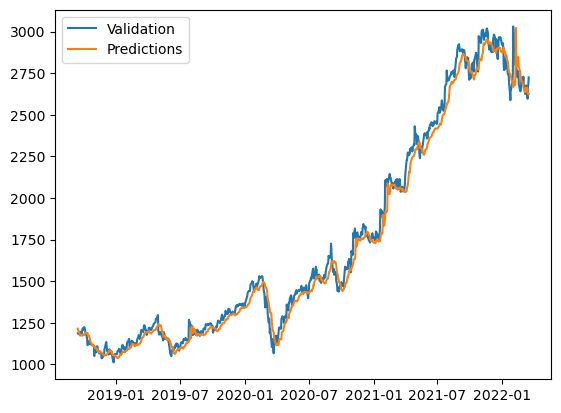

In [366]:
#Plot
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

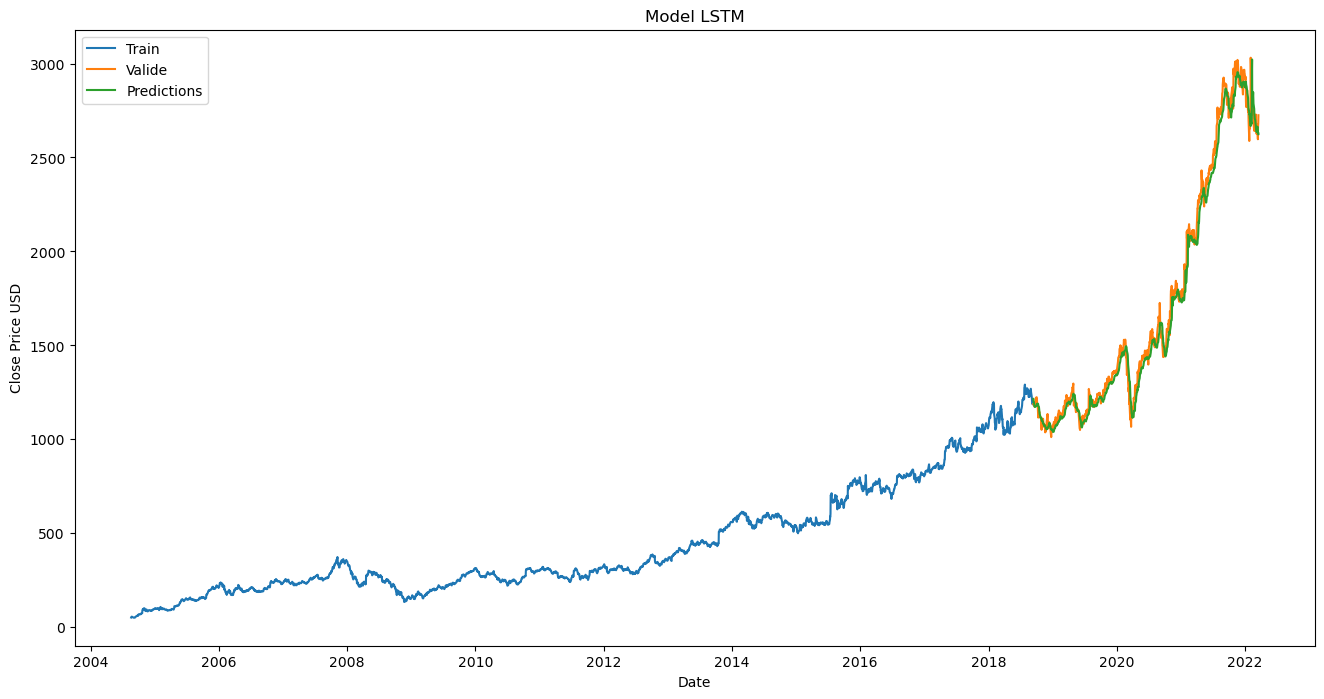

In [367]:
#Plot
train = new_dataset[:train_len]
valid = pd.DataFrame(new_dataset[train_len:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['High','Predictions']])
plt.legend(['Train','Valide','Predictions'])
plt.show()

In [368]:
#Change steps in order to shift down and reduce error
train_error=[]
test_error=[]

step_number=[5,8,10,15,20,30,40]
for i in step_number:
    #Train dataset___________________________________________________________________
    train_data = new_dataset[0:train_len]

    X_train=[]
    Y_train=[]

    for i in range(step, len(train_data)):
        X_train.append(train_data[i-step:i])
        Y_train.append(train_data[i])

    X_train, Y_train= np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    #Test dataset___________________________________________________________________
    test_data = new_dataset[train_len-step:]

    X_test=[]
    Y_test=[] 

    for i in range(step, len(test_data)):
        X_test.append(test_data[i-step:i])
        Y_test.append(test_data[i])

    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    #LSTM model________________________________________________________________
    model=Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)
    #Accuracy___________________________________________________________________
    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_test)
    train_error.append(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
    test_error.append(np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

28/28 [==============================] - 0s 6ms/step


In [369]:
train_error

[12.102700808486128,
 17.406756279369233,
 12.396017685255648,
 11.499493590953271,
 8.973599871781879,
 14.57473168868488,
 20.577399462818363]

In [370]:
test_error

[47.09727479160606,
 64.73862430840597,
 45.51390661593006,
 45.459329866902394,
 37.21412813046154,
 52.26180662493075,
 75.21316402002438]

In [371]:
pd.concat([pd.DataFrame(train_error,columns=['train_error']),
           pd.DataFrame(test_error,columns=['test_error']),
           pd.DataFrame([5,8,10,15,20,30,40],columns=['step'])], axis=1).set_index('step')

,train_error,test_error
step,,
5,12.102701,47.097275
8,17.406756,64.738624
10,12.396018,45.513907
15,11.499494,45.459330
20,8.973600,37.214128
30,14.574732,52.261807
40,20.577399,75.213164


In [373]:
#lowest errors is for steps 15
step=15

# Second test
#Train dataset
train_data = new_dataset[0:train_len]
X_train=[]
Y_train=[]
for i in range(step, len(train_data)):
    X_train.append(train_data[i-step:i])
    Y_train.append(train_data[i])

X_train, Y_train= np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#Test dataset_______________________________________________________________
test_data = new_dataset[train_len-step:]
X_test=[]
Y_test=[] 
for i in range(step, len(test_data)):
    X_test.append(test_data[i-step:i])
    Y_test.append(test_data[i])
    
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [374]:
#To increase accuracy we need to increse complexity
# adding layers and more LSTM cell
# 2 layers and 2 LSTM
#take more time to train -- more complex
model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))
opt1= tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

#Compile LSTM
model.compile(loss='mean_squared_error', optimizer=opt1)
model.summary()
model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_145 (LSTM)             (None, 15, 50)            10400     
                                                                 
 lstm_146 (LSTM)             (None, 50)                20200     
                                                                 
 dense_246 (Dense)           (None, 100)               5100      
                                                                 
 dense_247 (Dense)           (None, 25)                2525      
                                                                 
 dense_248 (Dense)           (None, 1)                 26        
                                                                 
Total params: 38,251
Trainable params: 38,251
Non-trainable params: 0
_________________________________________________________________


In [375]:
lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

28/28 [==============================] - 0s 8ms/step
Train rmse: 6.836311768565834
Validation rmse: 28.630432505336437


In [376]:
valid = pd.DataFrame(new_dataset[train_len:])
valid['Predictions']=lstm_valid_pred

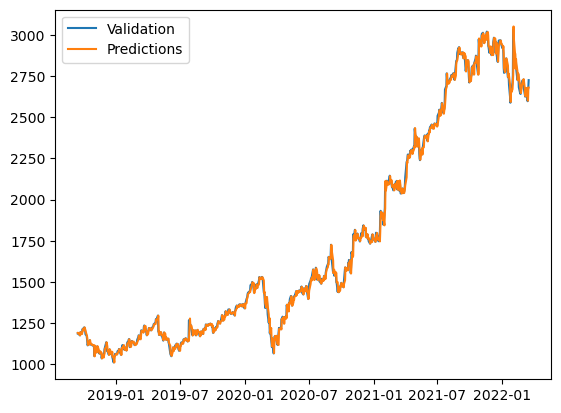

In [377]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()


In [378]:
#Regularization with dropout()

model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=opt1)
model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)


28/28 [==============================] - 0s 9ms/step


In [379]:
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

Train RMSE: 26.88069719467461
Validation RMSE: 99.58721753269002


In [380]:
#Regularization with dropout()

model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dropout(0.6))
model.add(Dense(25))
model.add(Dense(1))
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=opt1)
model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)

28/28 [==============================] - 0s 8ms/step


In [381]:
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

Train RMSE: 18.36640235273831
Validation RMSE: 92.51500479267924


In [382]:
#Change of optimizer 

model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dropout(0.6))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adadelta')
model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)

28/28 [==============================] - 0s 6ms/step


In [383]:
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

Train RMSE: 278.6103772537747
Validation RMSE: 944.9115216585708


In [384]:
#Change of optimizer 

model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dropout(0.6))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='RMSProp')
model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)

28/28 [==============================] - 0s 6ms/step


In [385]:
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

Train RMSE: 36.986111676882906
Validation RMSE: 137.92392725331754


In [388]:
#Change of optimizer 

model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dropout(0.6))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adamax')
model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)

28/28 [==============================] - 0s 9ms/step


In [389]:
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))

Train RMSE: 22.227272720781
Validation RMSE: 88.80863207706845


In [390]:
#the overfitting was not the problem

In [391]:
#Change the model to RNN
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_test)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)),2))

28/28 [==============================] - 0s 4ms/step


In [392]:
r1, statistics.mean(r1), statistics.stdev(r1)

([7.03, 7.92, 9.7, 6.84, 8.66, 7.26, 10.62, 7.63, 13.9, 6.85],
 8.641,
 2.2408106172147217)

In [393]:
r2, statistics.mean(r2), statistics.stdev(r2)

([29.38, 32.08, 37.37, 29.21, 34.07, 30.0, 41.57, 30.98, 51.25, 29.17],
 34.508,
 7.149768916234675)

In [394]:
valid = pd.DataFrame(new_dataset[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2018-09-13,1187.859985,1188.939209
2018-09-14,1188.000000,1185.598389
2018-09-17,1181.819946,1186.142212
2018-09-18,1181.329956,1178.839355
2018-09-19,1176.270020,1179.376099
...,...,...
2022-03-14,2608.179932,2674.368164
2022-03-15,2597.090088,2590.703613
2022-03-16,2666.659912,2590.258789


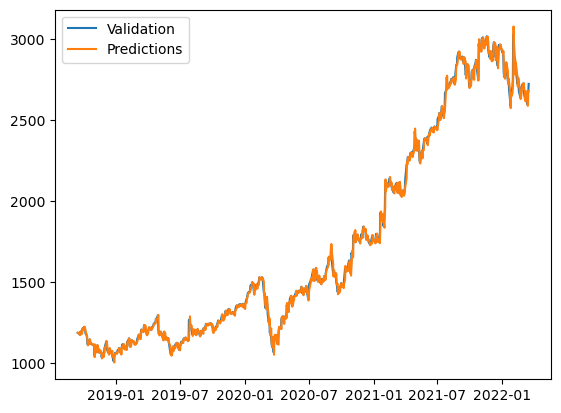

In [395]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()